In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
from pylib.utils.functions_for_classification import mixed_2d_2cls, plot_scatter
import matplotlib.pyplot as plt

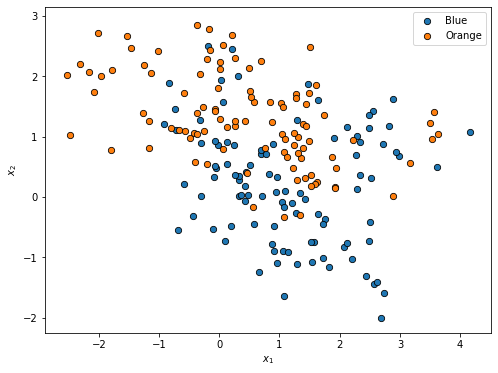

In [3]:
X_train, X_test, y_train, y_test = mixed_2d_2cls()
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train)
plt.show()

## 决策树

In [4]:
from pylib.utils.functions_for_classification import plot_decision_boundary
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import plot_tree
import numpy as np

In [5]:
class DecisionTree(BaseEstimator):
    """
     决策树
     
     参数
     ----
     split_loss_function: 损失函数
     leaf_value_estimator: 叶子节点的估计方法
     depth: 树的深度标记，默认为0，表示根节点
     min_sample_leaf: 叶子节点所允许包含的最小样本数量
     max_depth: 限制树的最大深度
     
     属性：
     -----
     best_sets：
     """
    # 跟踪每一次分割所用的特征，它的分割点和损失值（杂质）
    global best_sets
    best_sets = []
    def __init__(self, split_loss_function, leaf_value_estimator, 
                 depth=0, min_sample_leaf=5, max_depth=10):
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample_leaf = min_sample_leaf
        self.max_depth = max_depth
        
        # 初始化树的内部参数
        self.__initialize_tree()
        
    def __initialize_tree(self):
        self.is_leaf = None
        self.split_id = None
        self.split_value = None
        self.left = None
        self.right = None
        self.value = None
        self.loss = None
        
    
    def fit(self, X, y=None):
        """
        建立树：使用贪婪的、至上而下的递归算法
        """
        # 两个停止树增长的条件
        # 1.当树的深度到达最大深度时
        if self.depth == self.max_depth:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        # 2.当节点的样本数小于其所允许包含的最小样本数量时
        if len(y) <= self.min_sample_leaf:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        # 如果不满足停止树的增长条件，则继续分支
        # 找到最优特征和其最优分割位置
        loss_before = self.split_loss_function(y)
        # 记录最优特征
        best_split_value = None
        #  记录最优特征的索引
        best_split_id = None  
        # 记录最优的分割位置
        best_pos = None
        # 记录最优分割的损失值
        best_loss = self.split_loss_function(y)
        best_left_X = None
        best_right_X = None
        best_left_y = None
        best_right_y = None 
#         self.best_set = None
        
        n_samples, n_features = X.shape
        # 联结X和y以便于排序
        Xy = np.c_[X, y]
        # 遍历每个特征以寻找最优的分割特征和在该特征中的最优分割位置
        for i in range(n_features): 
            # 对每个特征进行排序
            Xy = Xy[np.argsort(Xy[:, i])]
            for split_pos in range(n_samples):
                # 根据分割位置将数据分割成左右两部分
                left_X = Xy[:split_pos+1,:-1]
                left_y = Xy[:split_pos+1,-1].reshape(-1,1)
                right_X = Xy[split_pos+1:,:-1]                
                right_y = Xy[split_pos+1:,-1].reshape(-1,1)
                # 计算左右两部分的损失值
                loss_left = len(left_y) * self.split_loss_function(left_y) / len(y)
                loss_right = len(right_y)*self.split_loss_function(right_y)/len(y)
                
                # 如果左右两个分支的损失值之和小于前一个的损失值之和，则更新最优参数
                if ((loss_left + loss_right) < best_loss):
                    best_split_value = Xy[split_pos,i]
                    best_pos = split_pos
                    best_split_id = i  
                    best_loss = loss_left + loss_right
                    best_left_X = left_X
                    best_right_X = right_X
                    best_left_y = left_y
                    best_right_y = right_y
        # 合并记录各个分割参数
        self.best_set = {"best split feature": best_split_value,
                             "best split id": best_split_id,
                             "best loss": best_loss}
        best_sets.append(self.best_set)

        # 根据最优变量和其最优分割点进行分割
        if best_split_id != None:
            self.left = DecisionTree(
                self.split_loss_function, self.leaf_value_estimator, self.depth + 1,
                self.min_sample_leaf, self.max_depth)
            self.right = DecisionTree(
                self.split_loss_function, self.leaf_value_estimator, self.depth + 1,
                self.min_sample_leaf,self.max_depth)
            # 用左右两个子树继续拟合数据
            self.left.fit(best_left_X, best_left_y)
            self.right.fit(best_right_X, best_right_y)
            self.split_id = best_split_id
            self.split_value = best_split_value
            self.loss = best_loss
            
        else: 
            # 如果是叶子节点，则估计它的值
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            
        return self

    def predict_instance(self, instance):
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

In [6]:
# 度量节点杂质：计算基尼系数
def compute_gini(y):
    labels = np.unique(y)
    gini = 0
    for label in labels:
        p = np.sum(y == label) / len(y)
        gini += p*(1-p)
    return gini

In [7]:
# 度量节点杂质：计算熵
def compute_entropy(self, y):
    labels = np.unique(y)
    entropy = 0
    for label in labels:
        p = np.sum(y == label) / float(len(y))
        entropy += -p * np.log(p)
    return entropy

In [8]:
# 找到最常出现的类别
def most_common_label(y):
    most_common = None
    max_count = 0
    labels = np.unique(y)
    for label in labels:
        count = len(y[y == label])
        if count > max_count:
            most_common = label
            max_count = count
    return most_common

In [10]:
class ClassificationTree(BaseEstimator, ClassifierMixin):
    """
    分类树
    
    参数：
    -----
    loss_function: 损失函数
    min_sample_leaf: 叶子节点所允许包含的最小样本数量
    max_depth: 限制树的最大深度
    """
    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini}
    
    def __init__(self, loss_function='gini', min_sample_leaf=5, max_depth=10):
        self.tree = DecisionTree(self.loss_function_dict[loss_function],
                                  most_common_label, 0, min_sample_leaf, max_depth)
    
    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value
    
    def predict(self, X):
        y_pred = [self.predict_instance(instance) for instance in X]
        return y_pred

In [11]:
tree = ClassificationTree(max_depth=2)
tree.fit(X_train, y_train)

ClassificationTree(loss_function=None, max_depth=None, min_sample_leaf=None)

In [12]:
train_err = 1 - tree.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.225


In [13]:
test_err = 1 - tree.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.288


In [14]:
# 分割情况
best_sets

[{'best split feature': 0.137389748,
  'best split id': 1,
  'best loss': 0.37422037422037413},
 {'best split feature': 2.742092422,
  'best split id': 0,
  'best loss': 0.1085972850678733},
 {'best split feature': 2.228716379,
  'best split id': 0,
  'best loss': 0.40614442567567566}]

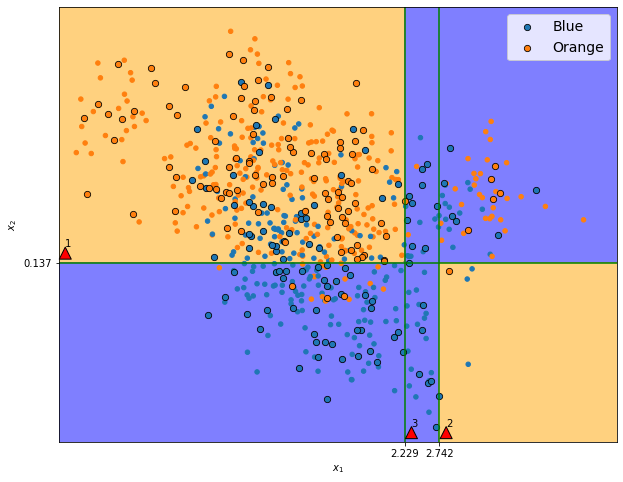

In [15]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, tree)
plt_xmin = plt.xlim()[0]
plt_xmax = plt.xlim()[1]
plt_ymin = plt.ylim()[0]
plt_ymax = plt.ylim()[1]
split = 0
x1_thresholds = []
x2_thresholds = []
for i, best_set in enumerate(best_sets):
    f = best_set["best split id"]
    threshold = best_set["best split feature"]
    if  f == 0:
        split += 1
        plt.vlines(threshold, plt_ymin, plt_ymax, color='g')
        plt.annotate('{}'.format(split), 
                     xy=(threshold + 0.1, plt_ymin + 0.2),
                     arrowprops=dict(facecolor='red'))
        x1_thresholds.append(np.round(threshold, 3))
    elif f == 1:
        split += 1
        plt.hlines(threshold, plt_xmin, plt_xmax, color='g')
        plt.annotate('{}'.format(split), 
                     xy=(plt_xmin + 0.1, threshold + 0.2),
                     arrowprops=dict(facecolor='red'))
        x2_thresholds.append(np.round(threshold, 3))
    else:
        continue
plt.xticks(x1_thresholds)
plt.yticks(x2_thresholds)
plt.show()

### 使用`Sklearn`

In [16]:
from sklearn.tree import DecisionTreeClassifier
import ipyvolume.pylab as plt3d

In [17]:
sk_tree = DecisionTreeClassifier(max_depth=2, random_state=42)
sk_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [18]:
train_err = 1 - sk_tree.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.225


In [19]:
test_err = 1 - sk_tree.score(X_test, y_test)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.290


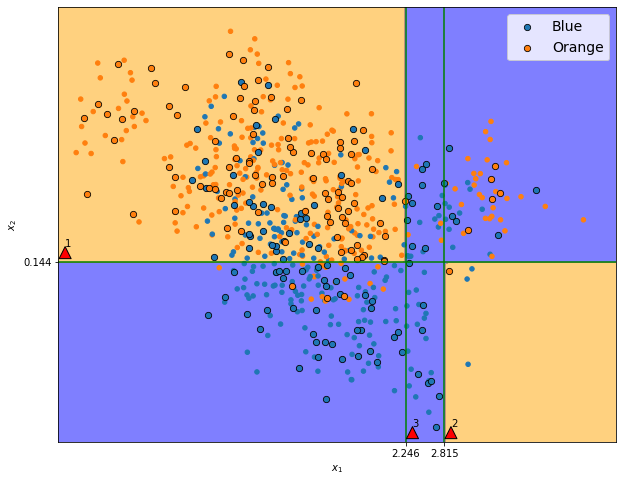

In [20]:
feature_path = sk_tree.tree_.feature
thresholds = sk_tree.tree_.threshold
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, sk_tree)
plt_xmin = plt.xlim()[0]
plt_xmax = plt.xlim()[1]
plt_ymin = plt.ylim()[0]
plt_ymax = plt.ylim()[1]
split = 0
x1_thresholds = []
x2_thresholds = []
for i, f in enumerate(feature_path):
    if  f == 0:
        split += 1
        plt.vlines(thresholds[i], plt_ymin, plt_ymax, color='g')
        plt.annotate('{}'.format(split), 
                     xy=(thresholds[i] + 0.1, plt_ymin + 0.2),
                     arrowprops=dict(facecolor='red'))
        x1_thresholds.append(np.round(thresholds[i], 3))
    elif f == 1:
        split += 1
        plt.hlines(thresholds[i], plt_xmin, plt_xmax, color='g')
        plt.annotate('{}'.format(split), 
                     xy=(plt_xmin + 0.1, thresholds[i] + 0.2),
                     arrowprops=dict(facecolor='red'))
        x2_thresholds.append(np.round(thresholds[i], 3))
    else:
        continue
plt.xticks(x1_thresholds)
plt.yticks(x2_thresholds)
plt.show()

In [21]:
n = 100
X = np.r_[X_train, X_test]
x1n, x2n = np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, n), \
           np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, n)
xx1n, xx2n = np.meshgrid(x1n, x2n)
XXn = np.c_[xx1n.ravel(), xx2n.ravel()]
yyn_proba = sk_tree.predict_proba(XXn)
yyn_proba = yyn_proba[:, 1].reshape(xx1n.shape)

plt3d.figure(width=1000, height=500)
plt3d.plot_surface(xx1n, yyn_proba, xx2n, color="green")
plt3d.xlabel("x1")
plt3d.zlabel("x2")
plt3d.ylabel("P")
plt3d.show()

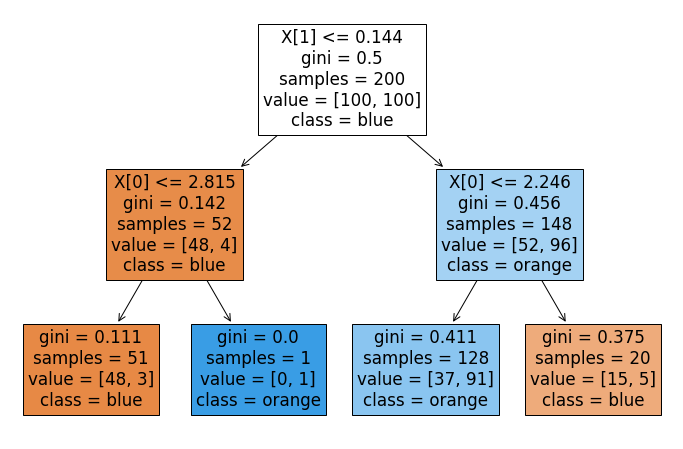

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(sk_tree, filled=True, ax=ax, class_names=["blue", "orange"])
plt.show()